# Deploy and monitor a machine learning workflow for Image Classification

1. __Data Staging__
    1. Extract the data from a hosting service
    2. Transform it into a usable shape and format
    3. Explore the data
    4. Filter the objects to find the label numbers for Bicycle and Motorcycles
    5. Convert the object into the dataframe
    6. Save the data to the local machine
    7. Load it into a production system
    
2. __Model Training__
    1. Create metadata for image classification on SageMaker
    2. Upload metadata to S3 using `boto3`
    3. Get algorithm using ECR image
    4. Create estimator
    5. Add hyperparameters to the estimator
    6. Add model inputs
    7. Fit the model

3. __Getting ready to deploy__
    1. Creating data capture
    2. Model deployment and creating the endpoint
    3. Instantiating a predictor
    4. Making Prediction
    
4. __Draft Lambdas and Step Function Workflow__
    1. Lambad 1: Serialize target data from S3
    2. Lambad 2: Classification of image
    3. Lambda 3: Check for confidence threshold
    
5. __Testing and Evaluation__
    1. Generating multiple test cases (event input for lambda 1)
    2. Pulling in the JSONLines data from your inferences
    3. Plotting the results


## 1. Data Staging

__A. Extract the data from the hosting service__

- In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. 
- The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 
- This will download a zip file

In [ ]:
download_url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
file_name = "cifar.tar.gz"

In [ ]:
import requests
import os

def extract_cifar_data(url, file_name="cifar.tar.gz"):
    """
    Downloads the CIFAR-100 dataset from the specified URL and saves it as a gzipped file.

    This function checks if the CIFAR-100 dataset file already exists in the local directory. 
    If it doesn't exist, the function downloads the dataset from the provided URL and saves 
    it locally with the given file name. The file is saved in binary format.

    Parameters:
    url (str): The URL from which the CIFAR-100 dataset will be downloaded.
    file_name (str): The name of the file where the downloaded dataset will be saved.
                     Defaults to "cifar.tar.gz" if not provided.

    Returns:
    None: This function does not return any value.
    """

    # Check if the file already exists in the local directory to avoid redundant downloads
    if not os.path.exists(file_name):
        # Send a GET request to the specified URL to retrieve the dataset
        response = requests.get(url)

        # Open the file in binary write mode to write the downloaded content
        with open(file_name, "wb") as file:
            # Write the content of the response (the dataset) to the file
            file.write(response.content)

        # No return value is necessary as the function is intended to save the file only

In [ ]:
extract_cifar_data(download_url, file_name)

__B. Transform the data into a usable shape and format__

- The zip file has 3 compressed form of python serialized object (serialized dict using pickle).
- So we will extract the zip and then unpickle them into python dict.
- Create a new folder `cifar-100-python`, containing `meta`, `test`, and `train` files, these are serialized python object. 
- These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. 

In [ ]:
import os
import tarfile

def unzip_data(file_name, mode="r:gz"):
    """
    Unzips a tar.gz file and extracts its contents.

    This function checks if a specific directory (cifar-100-python) already exists.
    If it does not, the function will extract all contents from the specified tar.gz file.

    Parameters:
    file_name (str): The name of the tar.gz file to be unzipped.
    mode (str, optional): The mode for opening the tar file. Defaults to "r:gz", which is read mode for gzipped tar files.

    Returns:
    None: This function does not return any value. It extracts files to the local directory.
    """

    # Check if the target directory 'cifar-100-python' already exists
    if not os.path.exists("cifar-100-python"):
        # Open the gzipped tar file in read mode
        with tarfile.open(file_name, mode) as tar:
            # Extract all the contents of the tar file to the current directory
            tar.extractall()

In [ ]:
import pickle

def de_serialize_pickle_data():
    """
    Deserialize CIFAR-100 dataset from pickle files.

    This function loads metadata, test data, and training data from pickle files
    for the CIFAR-100 dataset. It assumes that these files are stored in a directory
    named 'cifar-100-python' and uses the 'bytes' encoding for pickle loading.

    Returns:
        tuple: A tuple containing three elements in the following order:
               - dataset_meta: The metadata for the dataset.
               - dataset_test: The test data of the dataset.
               - dataset_train: The training data of the dataset.
    """
    # Load the metadata file
    with open("./cifar-100-python/meta", "rb") as f:
        # Deserialize metadata using pickle with 'bytes' encoding
        dataset_meta = pickle.load(f, encoding='bytes')

    # Load the test data file
    with open("./cifar-100-python/test", "rb") as f:
        # Deserialize test data using pickle with 'bytes' encoding
        dataset_test = pickle.load(f, encoding='bytes')

    # Load the training data file
    with open("./cifar-100-python/train", "rb") as f:
        # Deserialize training data using pickle with 'bytes' encoding
        dataset_train = pickle.load(f, encoding='bytes')
    
    return dataset_meta, dataset_test, dataset_train

In [ ]:
unzip_data(file_name)

In [ ]:
dataset_meta, dataset_test, dataset_train = de_serialize_pickle_data()

__C. Explore the data__

- All unpicked objects are Python dictionaries.
- The train dictionary has 5 keys:
    1. `b'filenames'`
    2. `b'batch_label'`
    3. `b'fine_labels'`
    4. `b'coarse_labels'`
    5. `b'data'`





- The test dictionary has 5 keys:
    1. `b'filenames'`
    2. `b'batch_label'`
    3. `b'fine_labels'`
    4. `b'coarse_labels'`
    5. `b'data'`
    
 
 
 - The meta dictionary has 2 keys:
    1. `b'fine_label_names'`
    2. `b'coarse_label_names'`
    3. `b'fine_labels'`
    4. `b'coarse_labels'`
    5. `b'data'`
    
    
    
- As documented on the homepage, `b'data'` 50000 contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row. So total = 32x32x3 = 3072 per index.


- `dataset_train[b'fine_labels']` contains the label for the image, this label act as index in `dataset_meta[b'fine_label_names']`


In [ ]:
def analysis_data():
    """
    Analyzes and prints the types and keys of training, testing datasets and metadata.

    This function is designed to work with a specific dataset format where the datasets
    and metadata are expected to be in a dictionary-like structure with specific keys.
    It prints out the types of various components of the datasets and metadata to
    help understand the structure and format of the data.
    """
    # Print the types of the main dataset, filenames, and fine labels in the training set
    print(type(dataset_train), type(dataset_train[b'filenames']), type(dataset_train[b'fine_labels']))

    # Print the types of metadata, test set, and training set
    print(type(dataset_meta), type(dataset_test), type(dataset_train))

    # Print the keys of training set, test set, and metadata for understanding their structure
    print(dataset_train.keys(), dataset_test.keys(), dataset_meta.keys())

    # Print the actual data in the training set, the length of the data array, and the length of the first element in the data array
    print(dataset_train[b'data'], len(dataset_train[b'data']), len(dataset_train[b'data'][0]))

Let's transform one of our images. 
Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [ ]:
!pip install matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_single_image(image_array):
    """
    Plot a single image from a flattened array.

    This function takes a flattened array representing an image and
    reconstructs it into a 32x32 RGB image. The input array is expected
    to have the first third of its elements representing the red channel,
    the second third the green channel, and the last third the blue channel.

    Parameters:
    image_array (numpy.ndarray): A flattened array of shape (3072,).
                                 It should contain 1024 elements (32x32) for each color channel.

    Returns:
    None: The function directly plots the image using matplotlib.
    """
    channel_size = 32 * 32  # Size of one color channel

    # Split the flattened array into red, green, and blue components
    red = image_array[0:channel_size]
    green = image_array[channel_size:2 * channel_size]
    blue = image_array[2 * channel_size:3 * channel_size]

    # Reshape each channel to a 32x32 grid
    red = red.reshape(32, 32)
    green = green.reshape(32, 32)
    blue = blue.reshape(32, 32)

    # Stack the channels along the third dimension to form a 32x32x3 RGB image
    combined = np.dstack((red, green, blue))

    # Display the image using matplotlib
    plt.imshow(combined)
    plt.show()  # This line ensures that the plot is displayed

In [ ]:
def analysis_labels():
    """
    This function prints the first five labels and their corresponding names from the training dataset.
    It also prints the name of the label and the filename associated with the first data entry in the dataset.

    The function assumes the existence of a training dataset `dataset_train` and a metadata set `dataset_meta`,
    both of which are expected to be dictionaries with byte string keys.
    """
    
    # Print the first five labels and their corresponding names from the training dataset
    print(dataset_train[b'fine_labels'][0:5], dataset_meta[b'fine_label_names'][0:5])
    
    # Print the label name for the first label in the training dataset
    print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][0]])
    
    # Print the filename associated with the first data entry in the dataset
    print(dataset_train[b'filenames'][0])


In [ ]:
analysis_data()

In [ ]:
plot_single_image(dataset_train[b'data'][0])

- Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [ ]:
analysis_labels()

- Index in `dataset_meta[b'fine_label_names']` are actually the labels.
- "Taurus" is the name of a subspecies of cattle.

__D. Filter the objects to find the label numbers for Bicycle and Motorcycles__

- CIFAR-100 has image for 100 classes, we need to filter the label that are accosicated with bicycle and motorcycle class.

In [ ]:
!pip3 install pandas

In [ ]:
def find_label():
    """
    Searches through a dataset's metadata to find specific labels.

    This function iterates over the 'fine_label_names' in 'dataset_meta' and
    prints out the name and index of labels that are either 'bicycle' or 'motorcycle'.

    Args:
    None: The function assumes 'dataset_meta' is a globally accessible variable 
          containing the dataset metadata.

    Returns:
    None: This function prints the label names and their corresponding indices, 
          but does not return any value.
    """
    # Iterate over each label in the dataset's metadata
    for index, label_name in enumerate(dataset_meta[b'fine_label_names']):
        # Check if the current label is either 'bicycle' or 'motorcycle'
        if label_name in [b'bicycle', b'motorcycle']:
            # Print the label name and its index
            print(f"Label Name: {label_name}, Label Number: {index}")

In [ ]:
find_label()

__E. Convert the object into the dataframe__

In [ ]:
import pandas as pd

def convert_to_df(dataset_train, dataset_test):
    """
    Convert training and testing datasets into pandas DataFrames.

    This function takes two datasets (training and testing) and converts them into pandas DataFrames. 
    It filters the datasets to include only rows where the label is either 8 or 48. 
    Additionally, it decodes the filenames from bytes to strings.

    Parameters:
    dataset_train (dict): A dictionary containing the training dataset with keys for 'filenames' and 'fine_labels'.
    dataset_test (dict): A dictionary containing the testing dataset with keys for 'filenames' and 'fine_labels'.

    Returns:
    tuple: A tuple containing two pandas DataFrames, one for the training data and the other for the testing data.
    """

    # Construct the dataframe for training data
    df_train = pd.DataFrame({
        "filenames": dataset_train[b'filenames'],
        "labels": dataset_train[b'fine_labels'],
        "row": range(len(dataset_train[b'filenames']))  # Adding an index column
    })

    # Filter df_train to include only rows with labels 8 or 48
    df_train = df_train.loc[df_train["labels"].isin([8, 48])]

    # Decode filenames in df_train from bytes to regular strings
    df_train["filenames"] = df_train["filenames"].apply(lambda x: x.decode("utf-8"))

    # Construct the dataframe for testing data
    df_test = pd.DataFrame({
        "filenames": dataset_test[b'filenames'],
        "labels": dataset_test[b'fine_labels'],
        "row": range(len(dataset_test[b'filenames']))  # Adding an index column
    })

    # Filter df_test to include only rows with labels 8 or 48
    df_test = df_test.loc[df_test["labels"].isin([8, 48])]

    # Decode filenames in df_test from bytes to regular strings
    df_test["filenames"] = df_test["filenames"].apply(lambda x: x.decode("utf-8"))
    
    return df_train, df_test

In [ ]:
def analysis_df(df_train, df_test):
    """
    Perform and display basic analysis on two pandas DataFrames.

    This function prints the first few rows (head) and a descriptive
    statistical summary of two DataFrames, typically used for training
    and testing in machine learning contexts.

    Parameters:
    df_train (DataFrame): The training dataset as a pandas DataFrame.
    df_test (DataFrame): The testing dataset as a pandas DataFrame.

    Returns:
    None: This function does not return anything. It only prints DataFrame information.
    """
    
    # Print the first few rows of the training dataset to get an overview
    print(df_train.head())
    
    # Print descriptive statistics for the training dataset
    print(df_train.describe())
    
    # Print the first few rows of the testing dataset to get an overview
    print(df_test.head())
    
    # Print descriptive statistics for the testing dataset
    print(df_test.describe())

In [ ]:
df_train, df_test = convert_to_df(dataset_train, dataset_test)

In [ ]:
analysis_df()

- `df_train` and `df_test` have filename, lable, and index from original data dict

__F. Save the data to the local machine__

In [ ]:
!mkdir ./train # Create a 'train' directory in the current working directory
!mkdir ./test # Create a 'test' directory in the current working director

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

In [ ]:
def save_images(image_data_row_num, image_filename, target_folder_path, images_dataset):
    """
    Saves an image from a dataset to a specified folder.

    This function retrieves image data from a specified row in an image dataset and saves it
    to the target folder with the given filename. The image data is assumed to be in a specific
    format and is reshaped and stacked to form the final image.

    Arguments:
    image_data_row_num : int
        The row number in the dataset from which to retrieve image data.
    image_filename : str
        The filename under which the image will be saved.
    target_folder_path : str
        The path to the folder where the image will be saved.
    images_dataset : array-like
        The dataset containing the image data.
    """

    # Retrieve the image data from the specified row in the dataset.
    img_data = images_dataset[b'data'][image_data_row_num]

    # Process the image data: Reshape and stack it to form a three-channel image.
    # Assumes the image data is in row-major form and needs to be divided into three equal parts,
    # each corresponding to one color channel (e.g., RGB).
    target = np.dstack((
        img_data[0:1024].reshape(32, 32),  # Red channel
        img_data[1024:2048].reshape(32, 32),  # Green channel
        img_data[2048:].reshape(32, 32)  # Blue channel
    ))

    # Try to save the processed image to the specified path.
    try:
        # Construct the full path where the image will be saved.
        image_file_path = os.path.join(target_folder_path, image_filename)
        # Save the image using the matplotlib's imsave function.
        plt.imsave(image_file_path, target)
    except Exception as e:
        # If an error occurs, return an error message.
        return f"Error Saving {image_filename} to folder {target_folder_path} \n Error: {e}"

    # If the image is saved successfully, return a success message.
    return f"Successfully saved {image_filename} to folder {target_folder_path}."

In [ ]:
# Looping through each row of the train dataframe using itertuples for efficiency
for df_row in df_train.itertuples():
    # Calling the save_images function for each row in the train dataframe
    # Passing the current row's index, filenames, a path to save the images, and the train dataset
    # The save_images function is assumed to save images based on the provided parameters
    print(save_images(df_row.row, df_row.filenames, "./train", dataset_train))

# Similar process is repeated for the test dataframe
# Looping through each row of the test dataframe
for df_row in df_test.itertuples():
    # Calling the save_images function for each row in the test dataframe
    # Parameters are similar to the above but with the test dataset and path
    print(save_images(df_row.row, df_row.filenames, "./test", dataset_test))

__G. Load the data__

- Now we can load the data into S3.
- Using the sagemaker SDK grab the current region, execution role, and bucket.

In [ ]:
# Importing the SageMaker module from the AWS SDK
import sagemaker

# Setting the name of the S3 bucket to be used
bucket = "ml-flow-sidd"
# Printing the name of the default bucket
print("Default Bucket: {}".format(bucket))

# Setting the AWS region where the operations will be performed
region = "us-east-1"
# Printing the AWS region being used
print("AWS Region: {}".format(region))

# Defining the role ARN (Amazon Resource Name) for SageMaker execution
role = "arn:aws:iam::271232843618:role/service-role/AmazonSageMaker-ExecutionRole-20231021T211247"
# Printing the role ARN
print("RoleArn: {}".format(role))

With this data we can easily sync your data up into S3!

In [ ]:
import os

def save_to_s3(bucket):
    """
    Saves local 'train' and 'test' directories to an S3 bucket.

    This function sets the environment variable 'DEFAULT_S3_BUCKET' to the specified bucket name. 
    It then synchronizes the contents of the local 'train' and 'test' directories with the corresponding 
    directories in the specified S3 bucket.

    Parameters:
    bucket (str): The name of the S3 bucket where the data will be saved.

    Note: This function relies on the AWS CLI being installed and properly configured on the system.
    """

    # Set the environment variable for the default S3 bucket
    os.environ["DEFAULT_S3_BUCKET"] = bucket

    # Sync the local 'train' directory with the 'train' directory in the specified S3 bucket
    !aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/

    # Sync the local 'test' directory with the 'test' directory in the specified S3 bucket
    !aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

In [ ]:
save_to_s3(bucket)

## 2. Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths.

__A. Creating metadata for image classification on SageMaker__

In [ ]:
def to_metadata_file(df, prefix):
    """
    Convert a DataFrame to a metadata file with specific columns.

    This function takes a DataFrame and a prefix string as input. It modifies the DataFrame 
    by creating an 's3_path' column from 'filenames' column and modifies the 'labels' column. 
    It then saves a subset of this DataFrame to a tab-separated file with the specified prefix.

    Args:
    df (DataFrame): The DataFrame to be processed. It should contain 'filenames' and 'labels' columns.
    prefix (str): A string prefix for the output file name.

    Returns:
    None: The function writes to a file and does not return anything.
    """

    # Copy filenames to a new column 's3_path'
    df["s3_path"] = df["filenames"]

    # Convert labels, setting 0 where original label is 8, else 1
    df["labels"] = df["labels"].apply(lambda x: 0 if x == 8 else 1)

    # Selecting specific columns and saving them to a tab-separated file
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )

In [ ]:
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

__B. Uploading metadata to S3 using boto3__


In [ ]:
import boto3  # Importing the boto3 library to interact with AWS services.

def save_meta_to_s3(bucket):
    """
    Uploads 'train.lst' and 'test.lst' files to an AWS S3 bucket.

    This function creates a new session with AWS and uses the boto3 library
    to interact with the specified S3 bucket. It uploads two files, 'train.lst'
    and 'test.lst', from the local directory to the S3 bucket.

    Args:
    bucket (str): The name of the S3 bucket where the files will be uploaded.

    Returns:
    None
    """

    # Creating a new session with AWS.
    aws_session = boto3.Session()

    # Uploading 'train.lst' to the specified S3 bucket.
    aws_session.resource('s3').Bucket(bucket).Object('train.lst').upload_file('./train.lst')

    # Uploading 'test.lst' to the specified S3 bucket.
    aws_session.resource('s3').Bucket(bucket).Object('test.lst').upload_file('./test.lst')


In [ ]:
save_meta_to_s3(bucket)

__C. Getting algorithm using ECR image__

- Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. 
- Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below
- The retrieve method is used to get the ECR (Elastic Container Registry) URI for a pre-built SageMaker Docker image.

In [ ]:
def get_image(region):
    """
    Retrieves the latest Amazon SageMaker image URI for image classification in a specified region.

    This function uses the Amazon SageMaker API to retrieve the URI (Uniform Resource Identifier)
    of the latest image classification model available in the specified AWS region. This URI can be used
    to deploy the image classification model in that region.

    Args:
    region (str): The AWS region for which the image classification URI is requested.

    Returns:
    str: The URI of the latest image classification model for the specified region.
    """

    # Retrieve and return the latest image URI for image classification in the specified region
    return sagemaker.image_uris.retrieve("image-classification", region=region, version="latest")

In [ ]:
algo_image =get_image(region)

__D. Creating estimator__

In [ ]:
def get_s3_output_location(bucket):
    """
    Construct and return the S3 output location for storing models.

    This function takes an S3 bucket name as input and returns a string
    that represents the path in the S3 bucket where image models are stored.

    Parameters:
    bucket (str): The name of the S3 bucket.

    Returns:
    str: The full S3 path for storing image models.
    """
    # Format and return the S3 path specific for models, particularly image models
    return f"s3://{bucket}/models/image_model"

In [ ]:
def get_estimator(algo_image, role, s3_output_location):
    """
    Create and return a SageMaker Estimator.

    This function initializes a SageMaker Estimator with specified parameters. 
    The Estimator is used for training machine learning models in AWS SageMaker.

    Parameters:
    algo_image (str): The URI of the algorithm image to be used for training.
    role (str): The AWS IAM role with required permissions for SageMaker operations.
    s3_output_location (str): The S3 location for saving the output of model training.

    Returns:
    sagemaker.estimator.Estimator: An Estimator object initialized with the specified settings.

    Example:
    >>> estimator = get_estimator("image-uri", "sagemaker-role", "s3://output-location")
    >>> print(type(estimator))
    <class 'sagemaker.estimator.Estimator'>
    """

    # Initialize a SageMaker Estimator with the specified parameters
    return sagemaker.estimator.Estimator(
        image_uri=algo_image,             # URI of the algorithm image
        role=role,                        # AWS IAM role
        instance_count=1,                 # Number of instances to use for training
        instance_type='ml.p3.2xlarge',    # Type of instance to use for training
        output_path=s3_output_location,   # S3 path to store the output
        sagemaker_session=sagemaker.Session()  # Create a SageMaker session
    )


In [ ]:
s3_output_location = get_s3_output_location()

In [ ]:
img_classifier_model=get_estimator(algo_image, role, s3_output_location)

__E. Adding hyperparameters to the estimator__

In [ ]:
# Setting hyperparameters for the image classification model.
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32',  # Defines the shape of input images: 3 channels (RGB) and 32x32 pixels in size.
    num_classes=2,  # Specifies the number of classes for classification. In this case, there are 2 classes.
    num_training_samples=df_train.shape[0]  # Sets the number of training samples using the size of the training dataset.
)

__F. Adding model inputs__

In [ ]:
# Importing necessary modules from the sagemaker package.
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

# Defining the inputs for the model training process.
model_inputs = {
    # Setting up the training input. 
    # This specifies where the training data is stored (in an S3 bucket) and its content type.
    "train": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{bucket}/train/",  # Path to training data in the S3 bucket.
        content_type="application/x-image"  # The type of content, in this case, images.
    ),
    # Setting up the validation input.
    # This is similar to the training input but points to the validation dataset.
    "validation": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{bucket}/test/",  # Path to validation data in the S3 bucket.
        content_type="application/x-image"  # Content type for validation data.
    ),
    # Setting up the training list input.
    # This is typically a file that lists the training images and their labels.
    "train_lst": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{bucket}/train.lst",  # Path to the training list file.
        content_type="application/x-image"  # Content type for the list file.
    ),
    # Setting up the validation list input.
    # This is similar to the training list but for validation data.
    "validation_lst": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{bucket}/test.lst",  # Path to the validation list file.
        content_type="application/x-image"  # Content type for the validation list file.
    )
}

__G. Fitting the model__

In [ ]:
img_classifier_model.fit(inputs=model_inputs)

- If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good.
- We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.


## 3. Getting ready to deploy

__A. Creating data capture__

In [ ]:
# Import DataCaptureConfig from the sagemaker.model_monitor module.
# This is used to configure the capturing of data for SageMaker model endpoints.
from sagemaker.model_monitor import DataCaptureConfig

# Define the data capture configuration for a SageMaker model endpoint.
data_capture_config = DataCaptureConfig(
    enable_capture=True, # Enable capturing of input/output payloads for the endpoint.
    sampling_percentage=100, # Set to capture data from every request (100% sampling).
    destination_s3_uri=f"s3://{bucket}/data_capture" # Specify the S3 bucket URI where the captured data will be stored.
)


__B. Model deployment and creating the endpoint__

In [ ]:
# Deploying an image classification model using a deployment configuration.

# The 'deploy' method is used to deploy the trained model for serving predictions.
deployment = img_classifier_model.deploy(
    # 'instance_type' specifies the type of machine on which to deploy the model.
    # Here, "ml.m5.xlarge" is selected, which is a specific type of instance provided by the service.
    instance_type="ml.m5.xlarge",

    # 'initial_instance_count' indicates the number of instances to start for the deployment.
    # Here, it is set to 1, meaning the model will be deployed on a single instance.
    initial_instance_count=1,

    # 'data_capture_config' is the configuration for capturing input/output data from the model's predictions.
    # This is used for monitoring the model's performance and the data it is processing.
    data_capture_config=data_capture_config,
)

In [ ]:
endpoint = deployment.endpoint_name
print(endpoint)

__C. Instantiating a predictor__

In [ ]:
# Importing the SageMaker module from the AWS SDK
import sagemaker

# Creating an instance of the Predictor class from the SageMaker module.
predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint, # Specifying the name of the endpoint to send requests to.
    sagemaker_session=sagemaker.Session() # Creating a new SageMaker session.
)

__D. Making Prediction__

In [ ]:
# Import the IdentitySerializer class from SageMaker's serializers module.
from sagemaker.serializers import IdentitySerializer

# Import the base64 module for encoding operations.
import base64

# Set the serializer for the predictor. Here, IdentitySerializer is used to
# send the payload as-is without any transformation. The content type is set to 'image/png',
# indicating that the input will be an image in PNG format.
predictor.serializer = IdentitySerializer("image/png")

# Open an image file in read-binary mode. The image is located at "./test/bicycle_s_001789.png".
with open("./test/bicycle_s_001789.png", "rb") as f:
    # Read the contents of the file (the image data) into a variable named 'payload'.
    payload = f.read()

# Make a prediction using the predictor. The 'predict' method is called with the image data (payload).
# The 'initial_args' parameter specifies the content type of the input data as 'application/x-image',
# which is a general content type for images.
inference = predictor.predict(payload, initial_args={'ContentType': 'application/x-image'})

In [ ]:
print(inference)

- `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) 
- So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

## 4. Draft Lambdas and Step Function Workflow

- Create 3 lambda functions in AWS Lambda, I have provied the code below for all lambdas
- Also add AmazonS3FullAccess Policy for lambda 1, so that Lambda can access S3 bucket data

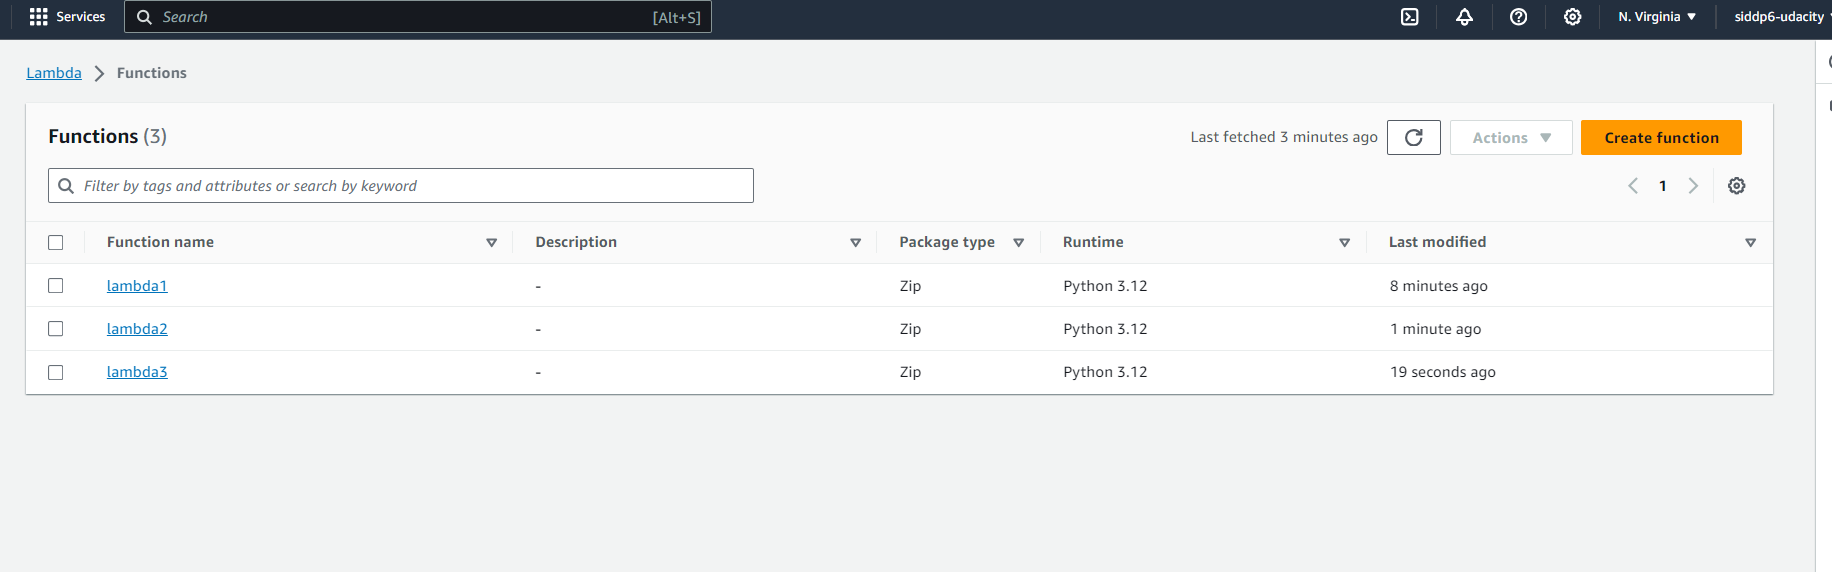

__A. Lambad 1: Serialize target data from S3__

- Download an image file from an S3 bucket
- Convert the image data into a base64-encoded format
- Return this data along with some metadata as a response

- event input
```
{
    "s3_key": "test/bicycle_s_000030.png",
    "s3_bucket": "ml-flow-sidd"
}
```

- The lambda_handler function is defined, which is the entry point for the Lambda function. 
- This function takes two parameters: event and context. 
- The event parameter contains information about the event that triggered the Lambda function


In [ ]:
import boto3
import base64  # For encoding and decoding data in base64 format

# Initialize an S3 client using boto3
s3 = boto3.client('s3')

def lambda_handler(event, context):
    """
    Handles an AWS Lambda event by retrieving an image from an S3 bucket, 
    encoding it in base64 format, and returning the encoded data along with S3 metadata.

    Args:
    event (dict): A dictionary containing 's3_key' and 's3_bucket', 
                  which are the key and bucket name of the S3 object to process.
    context (LambdaContext): Provides runtime information to the handler.
    
    Returns:
    dict: A dictionary containing the status code, base64 encoded image data, 
          and the S3 bucket and key information.
    """

    # Extract the S3 key and bucket information from the event
    key = event["s3_key"]
    bucket = event["s3_bucket"]
    
    # Download the data from S3 to a temporary location on the Lambda environment
    boto3.resource('s3').Bucket(bucket).download_file(key, "/tmp/image.png")
    
    # Open the downloaded image file for reading in binary mode
    with open("/tmp/image.png", "rb") as f:
        # Read the file and encode its content in base64
        image_data = base64.b64encode(f.read())

    # Return a dictionary containing the status code, base64 encoded image data, and S3 object information
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []  # Placeholder for any additional processing results
        }
    }

__B. Lambad 2: Classification of image__

- Creates a SageMaker runtime client using boto3.client('runtime.sagemaker') to interact with the SageMaker endpoint.
- Send an image (in base64-encoded format) to an Amazon SageMaker endpoint for inference 
- Return the inference results

In [ ]:
import boto3
import json
import base64

# The name of the endpoint in AWS SageMaker to be invoked
ENDPOINT_NAME = endpoint

# Create a SageMaker runtime client using Boto3. This is used to invoke the SageMaker endpoint.
runtime = boto3.client('runtime.sagemaker')

def lambda_handler(event, context):
    """
    Handles a Lambda function invocation for image processing.

    This function takes an event containing base64-encoded image data,
    decodes it, and sends it to a SageMaker endpoint for inference.
    It then returns the inference result in the response.

    Parameters:
    - event (dict): A dictionary containing the input data for the Lambda function. 
                    Expected to have a 'body' key with 'image_data' as base64-encoded string.
    - context: Information about the runtime environment. This is unused in this function.

    Returns:
    - dict: A dictionary with the status code and the body containing the inference result.
    """

    # Decode the base64-encoded image data from the event
    image = base64.b64decode(event['body']['image_data'])
    
    # Invoke the SageMaker endpoint with the decoded image
    response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='image/png',
                                       Body=image)
    
    # Decode the response and add it to the event dictionary under the key 'inferences'
    event["inferences"] = json.loads(response['Body'].read().decode('utf-8'))

    # Return the status code and the modified event as the response
    return {
        'statusCode': 200,
        'body': event
    }

__C. Lambda 3: Check for confidence threshold__

In [ ]:
import json

# Define the threshold for confidence
THRESHOLD = 0.8 

def lambda_handler(event, context):
    """
    Handler function for AWS Lambda to process inferences.

    This function takes an event containing inferences and evaluates if any of the inferences
    meet a predefined confidence threshold. If the threshold is met, it returns the event data,
    otherwise, it raises an exception.

    Parameters:
    event (dict): The event data containing 'inferences' key with a list of confidence values.
    context: The context in which the Lambda function is running, provided by AWS Lambda.

    Returns:
    dict: A dictionary with statusCode and the original event data in JSON format if the threshold is met.

    Raises:
    Exception: If none of the inferences meet the required confidence threshold.
    """

    # Extract inferences from the event body
    inferences =  event['body']['inferences']
    
    # Check if any values in our inferences are above the THRESHOLD
    # Iterates through each confidence score in inferences to check against THRESHOLD
    meets_threshold = any(confidence >= THRESHOLD for confidence in inferences)
    
    # Conditional action based on whether the threshold is met
    if meets_threshold:
        # Continue if at least one inference meets the threshold
        pass
    else:
        # Raise an exception if threshold is not met
        raise Exception("THRESHOLD_CONFIDENCE_NOT_MET")
    
    # Return the original event as a JSON string with a status code of 200
    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }

- Use Sag


## 5. Testing and Evaluation

__A. Generating multiple test cases (event input for lambda 1)__

In [ ]:
import random
import boto3
import json

def generate_test_case():
    """
    Generate a test case for an image processing system.

    This function selects a random object from the 'test/' folder of an S3 bucket
    and returns its key along with the bucket name in a JSON format. It's assumed
    that the S3 bucket contains test images for the system.

    Returns:
        str: A JSON string containing the S3 bucket name and the key of a randomly
             selected object from the 'test/' folder.
    """
    # Initialize a boto3 resource for Amazon S3
    s3 = boto3.resource('s3')
    
    # Filter objects in the specified S3 bucket with a prefix 'test/'
    # It assumes 'bucket' is a predefined variable representing the S3 bucket name
    objects = s3.Bucket(bucket).objects.filter(Prefix="test/")
    
    # Choose a random object from the filtered list
    # The list comprehension creates a list of object keys from the filtered objects
    obj = random.choice([x.key for x in objects])
    
    # Construct and return a JSON string with the necessary data
    # 'image_data' is left empty as a placeholder for any additional data if needed
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })

In [ ]:
generate_test_case()

__B. Pulling in the JSONLines data from your inferences__

    1. Downloading the capture (in JSONL format)
    2. Extracting JSONL format in dict
    3. Loading inferences along with timestamp
    4. Visulaizing (the input images, the resulting inferences, and the timestamps.)
    
 - The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file.

In [ ]:
# Importing the S3Downloader module from the sagemaker.s3 package.
# This module provides utilities for downloading data from Amazon S3 storage.
from sagemaker.s3 import S3Downloader

# Defining the S3 path where the data is stored.
# The data is organized in a datetime-aware format within the specified S3 bucket.
# This path points to a specific dataset related to image classification, captured on a specific date and time.
data_path = "s3://sidd0final0project0bucket/data_capture/image-classification-2023-10-25-10-26-31-173/AllTraffic/2023/10/26/14/"

# Using the S3Downloader to download the data from the specified S3 path.
# The data is downloaded and saved locally in a directory named 'captured_data'.
# This enables further processing or analysis of the downloaded data.
S3Downloader.download(data_path, "captured_data")


In [ ]:
# Importing the jsonlines library to work with JSONL files
!pip install jsonlines

import jsonlines
import os

# List the file names in the 'captured_data' directory
file_handles = os.listdir("./captured_data")

# Initialize an empty list to store JSON data
json_data = []
# Loop through each file in the directory
for jsonl in file_handles:
    # Open the JSONL file using jsonlines library
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        # Read the contents of the file and append it to the json_data list
        json_data.append(f.read())


In [ ]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

__C. Plotting the results__

In [ ]:
import matplotlib.pyplot as plt

# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Plot the data
plt.scatter(x, y, c=['r' if k<. else 'b' for k in y ])
plt.axhline(y=0.8, color='g', linestyle='--')
plt.ylim(bottom=.6)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(x, y)    
plt.xlabel("Inference")
plt.ylabel("Confidence Level")
plt.gcf().autofmt_xdate()
plt.show()